In [1]:
import math
import numpy as np
from IPython.display import clear_output
# from tqdm.notebook import trange, tqdm
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm
import re

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import os
import pandas as pd
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from einops import rearrange

In [2]:
NUM_EPOCHS = 100
HIDDEN_SIZE = 384
EMBEDDING_DIM = 100
COORDINATES_DIM = 120
BATCH_SIZE = 8
NUM_HEADS = 4
NUM_LAYERS = 2
LEARNING_RATE = 0.002
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu") 
DROPOUT = 0.1
CLIP = 1.0
WARMUP_EPOCHS = 10
TRAIN_DIR = Path("../../data_interior_4_train/")
TEST_DIR = Path("../../data_interior_4_test/")

In [3]:
writer = SummaryWriter()

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, max_index):
        self.words = pd.read_csv(TRAIN_DIR/"vocab.csv", index_col=0)["0"].values.tolist()
        self.vocab = ["<sos>", "<eos>", "<pad>", "<unk>"] + self.words
        self.vocab_size = len(self.vocab)
        self.index_to_word = {index: word for index, word in enumerate(self.vocab)}
        self.word_to_index = {word: index for index, word in enumerate(self.vocab)}
        self.block_size = 127
        self.max_index = max_index
        
    def __len__(self):
        return self.max_index
    
    def __getitem__(self, index):
        
        try:
            lst_tokens_src = np.loadtxt(
                             TRAIN_DIR/'entities_src_{}.txt'.format(index), dtype=str
                         )[:self.block_size-2].tolist()
            lst_tokens_trg = np.loadtxt(
                             TRAIN_DIR/'entities_trg_{}.txt'.format(index), dtype=str
                         )[:self.block_size-2].tolist()

            coord_tensor_src = torch.tensor(
                np.load(TRAIN_DIR/"coordinates_src_{}.npy".format(index)), 
                dtype = torch.float).t()[:self.block_size-2,:].to(DEVICE)
            coord_tensor_trg = torch.tensor(
                np.load(TRAIN_DIR/"coordinates_trg_{}.npy".format(index)), 
                dtype = torch.float).t()[:self.block_size-2,:].to(DEVICE)
        except:
            print(index, end = ", ")
            return ((torch.rand(2,2),torch.rand(2,2)), (torch.rand(2,2),torch.rand(2,2)))
        

        sentence_src = ["<sos>"] + lst_tokens_src + ["<eos>"]
        sentence_trg = ["<sos>"] + lst_tokens_trg + ["<eos>"]
        
        sentence_indices_src = [self.word_to_index[w] for w in sentence_src]
        sentence_indices_trg = [self.word_to_index[w] for w in sentence_trg]

        tokens_tenor_src = torch.tensor(sentence_indices_src).to(DEVICE)
        tokens_tenor_trg = torch.tensor(sentence_indices_trg).to(DEVICE)
        
        coord_padded_src = torch.cat([
            torch.zeros([1,4]).to(DEVICE),
            coord_tensor_src,
            torch.zeros([1,4]).to(DEVICE),
        ])
        
        coord_padded_trg = torch.cat([
            torch.zeros([1,4]).to(DEVICE),
            coord_tensor_trg,
            torch.zeros([1,4]).to(DEVICE),
        ])
        
        return ((tokens_tenor_src.unsqueeze(0).t(), coord_padded_src),
                (tokens_tenor_trg.unsqueeze(0).t(), coord_padded_trg))

In [5]:
l = [int(x[len("entities_src_"):][:-len(".txt")]) for x in 
        list(filter(None, 
        filter(lambda x: ".txt" in x and x != 'vocab.csv', 
               os.listdir(TRAIN_DIR))))]
max_index = max(l)
train_dataset = Dataset(max_index)

In [6]:
l = [int(x[len("entities_src_"):][:-len(".txt")]) for x in 
        list(filter(None, 
        filter(lambda x: ".txt" in x and x != 'vocab.csv', 
               os.listdir(TEST_DIR))))]
max_index = max(l)
test_dataset = Dataset(max_index)

In [7]:
VOCAB_SIZE = train_dataset.vocab_size

In [8]:
class PadSequence:
    def __call__(self, batch):
        len_batch = len(batch)
        max_len_X = max([batch[i][0][0].shape[0] for i in range(len_batch)])
        max_len_y = max([batch[i][1][0].shape[0] for i in range(len_batch)])
#         max_len = max(max_len, 30)
        X_tok_batch = torch.zeros([1, max_len_X, 1], dtype = torch.int) 
        X_coord_batch = torch.zeros([1, max_len_X, 4]) 
        y_tok_batch = torch.zeros([1, max_len_y, 1], dtype = torch.int) 
        y_coord_batch = torch.zeros([1, max_len_y, 4]) 
        for i in range(len_batch):
            (X_tok, X_coord), (y_tok, y_coord) = batch[i]

            cur_len_X = X_tok.shape[0]
            cur_len_y = y_tok.shape[0]
            X_tok = torch.cat([
                            X_tok, 
                            torch.ones([max_len_X - cur_len_X, 1], dtype = torch.int).to(DEVICE) * \
                                train_dataset.word_to_index["<pad>"]
                            ], dim = 0)
            X_coord = torch.cat([X_coord, torch.zeros([max_len_X - cur_len_X, 4]).to(DEVICE)], dim = 0)
            y_tok = torch.cat([
                            y_tok, 
                            torch.ones([max_len_y - cur_len_y, 1], dtype = torch.int).to(DEVICE) * \
                                train_dataset.word_to_index["<pad>"]
                            ], dim = 0)
            y_coord = torch.cat([y_coord, torch.zeros([max_len_y - cur_len_y, 4]).to(DEVICE)], dim = 0)
            batch[i] = (X_tok, X_coord), (y_tok, y_coord)

            X_tok_batch = torch.cat([X_tok_batch, X_tok.unsqueeze(0)], dim = 0).to(DEVICE)
            X_coord_batch = torch.cat([X_coord_batch, X_coord.unsqueeze(0)], dim = 0).to(DEVICE)
            y_tok_batch = torch.cat([y_tok_batch, y_tok.unsqueeze(0)], dim = 0).to(DEVICE)
            y_coord_batch = torch.cat([y_coord_batch, y_coord.unsqueeze(0)], dim = 0).to(DEVICE)
            
        X_tok_batch = X_tok_batch[1:,:,:]
        X_coord_batch = X_coord_batch[1:,:,:]
        y_tok_batch = y_tok_batch[1:,:,:]
        y_coord_batch = y_coord_batch[1:,:,:]
        
        return (X_tok_batch, X_coord_batch), (y_tok_batch, y_coord_batch)

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [10]:
def gen_nopeek_mask(length):
    """
     Returns the nopeek mask
             Parameters:
                     length (int): Number of tokens in each sentence in the target batch
             Returns:
                     mask (arr): tgt_mask, looks like [[0., -inf, -inf],
                                                      [0., 0., -inf],
                                                      [0., 0., 0.]]
     """
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

    return mask

In [11]:
class TransformerNet(nn.Module):
    def __init__(self, num_vocab, embedding_dim, coord_dim, hidden_size, nhead, n_layers, dropout):
        super(TransformerNet, self).__init__()
        self.tok_emb = nn.Embedding(num_vocab, embedding_dim)
        self.coord_emb = nn.Linear(4, coord_dim)
        self.d_model = embedding_dim+coord_dim
        self.pos_enc = PositionalEncoding(d_model=embedding_dim+coord_dim, 
                                          dropout=dropout, max_len=200)
        
        self.transformer = nn.Transformer(d_model=embedding_dim+coord_dim, nhead=nhead, 
                                          num_encoder_layers=n_layers, num_decoder_layers=n_layers, 
                                          dim_feedforward=hidden_size, dropout=dropout)
        self.fc_tok = nn.Linear(embedding_dim+coord_dim, num_vocab)
        self.fc_coord = nn.Linear(embedding_dim+coord_dim, 4)
#         self.log_softmax = nn.LogSoftmax(dim = 2)

    def forward(self, lst_arg):
        (X_tok, X_coord), (y_tok, y_coord) = lst_arg
        
        trg_mask = gen_nopeek_mask(y_tok.shape[1]).to(DEVICE)
        
        token_embeddings_src = self.tok_emb(X_tok[:,:,0]) # [bs, seq_len, emb ]
        coord_embeddings_src = self.coord_emb(X_coord) # [bs, seq_len, emb_coord ]
        src = torch.cat([token_embeddings_src, coord_embeddings_src], dim = 2)
        src = torch.transpose(src, 0,1)
        
        token_embeddings_trg = self.tok_emb(y_tok[:,:,0]) # [bs, seq_len, emb ]
        coord_embeddings_trg = self.coord_emb(y_coord) # [bs, seq_len, emb_coord ]
        trg = torch.cat([token_embeddings_trg, coord_embeddings_trg], dim = 2)
        trg = torch.transpose(trg, 0,1)

        src = self.pos_enc(src * math.sqrt(self.d_model))
        trg = self.pos_enc(trg * math.sqrt(self.d_model))
        
        x = self.transformer(src, trg, tgt_mask = trg_mask)
        
        return (self.fc_tok(x).transpose(0,1), self.fc_coord(x).transpose(0,1))

In [12]:
model = TransformerNet(VOCAB_SIZE, EMBEDDING_DIM, COORDINATES_DIM, HIDDEN_SIZE, NUM_HEADS, 
                       NUM_LAYERS, DROPOUT).to(DEVICE)
criterion_tok = nn.CrossEntropyLoss(reduction="sum")
criterion_coord = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [13]:
model.load_state_dict(torch.load("../../interior_transformer_model_v2.pt", 
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
sum(p.numel() for p in model.parameters())

1866024

In [15]:
loader = DataLoader(train_dataset, shuffle=False, pin_memory=True,
                    batch_size=BATCH_SIZE,
                    num_workers=0,
                    drop_last = True, collate_fn=PadSequence())

In [16]:
test_loader = DataLoader(test_dataset, shuffle=True, pin_memory=True,
                    batch_size=1,
                    num_workers=0,
                    drop_last = True, collate_fn=PadSequence())

In [17]:
def evaluate(model):
    model.eval()
    for i, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
        break
    (X_tok, X_coord) = x

    sos_idx = train_dataset.word_to_index["<sos>"]
    output_tok = torch.tensor([[[sos_idx]]]).transpose(1,2)
    output_coord = torch.zeros([1,1,4])

    for i in range(100):
        model_out_tok, model_out_coord = model((x, (output_tok, output_coord)))
        pred_tok = model_out_tok[0,-1,:].argmax()
        pred_coord = model_out_coord[0,-1,:]
        output_tok = torch.cat([output_tok, pred_tok.view(1,1,1)], dim = 1)
        output_coord = torch.cat([output_coord, pred_coord.view(1,1,4)], dim = 1)
        if pred_tok == train_dataset.word_to_index["<eos>"]:
            break
    
    lst_tok = [train_dataset.index_to_word[i] for i in output_tok[0,:,0].tolist()]
    lst_gt  = [train_dataset.index_to_word[i] for i in y[0][0,:,0].tolist()]
    
    print("GT: ", lst_gt[:100])
    print("PRED: ", lst_tok[:100])

In [ ]:
loss_trace = []
model.train()
n_iter = 0
lr = LEARNING_RATE

for epoch in range(NUM_EPOCHS):
    model.train()
    current_loss = 0
    for i, (x, y) in tqdm(enumerate(loader), total=len(loader)):
        y_tok, y_coord = y
        b, t, _ = y_tok.size()

        logits_tok, pred_coord = model((x, (y_tok[:,:-1,:], y_coord[:,:-1,:])))
        
        loss_1 = criterion_tok(logits_tok.reshape(-1, logits_tok.size(-1)), y_tok[:,1:,:].reshape(-1))
        loss_2 = criterion_coord(pred_coord, y_coord[:,1:,:])
        loss_1 = loss_1 / b
        loss_2 = loss_2 / b
        loss = loss_1 + loss_2
        writer.add_scalar('Loss/cross_entropy', loss_1.item(), n_iter)
        writer.add_scalar('Loss/MSE', loss_2.item(), n_iter)
        writer.add_scalar('Loss/general_loss', loss.item(), n_iter)
        writer.add_scalar('LR/lr', lr, n_iter)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()
        current_loss += loss.item()
        n_iter += 1
        if i > 10:
            break
    loss_trace.append(current_loss)
    print(current_loss)
    
    if epoch < WARMUP_EPOCHS:
        # linear warmup
        lr_mult = float(epoch) / float(max(1, WARMUP_EPOCHS))
    else:
        # cosine learning rate decay
        progress = float(epoch - WARMUP_EPOCHS) / float(max(1, NUM_EPOCHS/3.6 - WARMUP_EPOCHS))
        lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
    lr = LEARNING_RATE * lr_mult + lr*0.01
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    if epoch % 10 == 0:
        torch.save(model.state_dict(), "./interior_transformer_model_v2.pt")
        evaluate(model)

# loss curve
plt.plot(range(1, NUM_EPOCHS+1), loss_trace, 'r-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [20]:
model.eval()
;

''

In [21]:
l = [int(x[len("entities_src_"):][:-len(".txt")]) for x in 
        list(filter(None, 
        filter(lambda x: ".txt" in x and x != 'vocab.csv', 
               os.listdir(TEST_DIR))))]
max_index = max(l)
test_dataset = Dataset(max_index)

In [22]:
test_loader = DataLoader(test_dataset, shuffle=True, pin_memory=True,
                    batch_size=1,
                    num_workers=0,
                    drop_last = True, collate_fn=PadSequence())

In [181]:
loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                    batch_size=1,
                    num_workers=0,
                    drop_last = True, collate_fn=PadSequence())

In [193]:
for i, (x, y) in tqdm(enumerate(loader), total=len(loader)):
    break

  0%|          | 0/79186 [00:00<?, ?it/s]


In [194]:
(X_tok, X_coord) = x
token_embeddings_src = model.tok_emb(X_tok[:,:,0]) # [bs, seq_len, emb ]
coord_embeddings_src = model.coord_emb(X_coord) # [bs, seq_len, emb_coord ]
src = torch.cat([token_embeddings_src, coord_embeddings_src], dim = 2)
src = torch.transpose(src, 0,1)
src = model.pos_enc(src * math.sqrt(model.d_model))

In [195]:
model.eval()
sos_idx = train_dataset.word_to_index["<sos>"]
output_tok = torch.tensor([[[sos_idx]]]).transpose(1,2)
output_coord = torch.zeros([1,1,4])
# output_tok = y[0][:,:2,:]
# output_coord = y[1][:,:2,:]

for i in range(100):
    model_out_tok, model_out_coord = model((x, (output_tok, output_coord)))
    pred_tok = model_out_tok[0,-1,:].argmax()
    pred_coord = model_out_coord[0,-1,:]
    output_tok = torch.cat([output_tok, pred_tok.view(1,1,1)], dim = 1)
    output_coord = torch.cat([output_coord, pred_coord.view(1,1,4)], dim = 1)
    if pred_tok == train_dataset.word_to_index["<eos>"]:
        break

In [196]:
lst_tok = [train_dataset.index_to_word[i] for i in output_tok[0,:,0].tolist()]

In [197]:
print(lst_tok)

['<sos>', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'door', 'entrance', 'no_point', 'closet', 'closet', 'closet', 'closet', 'washing_basin', 'washing_basin', 'washing_basin', 'washing_basin', 'washing_basin', 'washing_basin', 'washing_basin', 'bedroom', 'kitchen', 'corridor', 'corridor', 'corridor', 'corridor', 'corridor', 'corridor', 'corridor', 'corridor', 'corridor', 'corridor', 'corridor', 'corridor', 'cooking_counter', 'restroom', 'restroom', 'restroom', 'bathtub', 'toilet', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'balcony', 'ba

In [198]:
len(lst_tok)

102

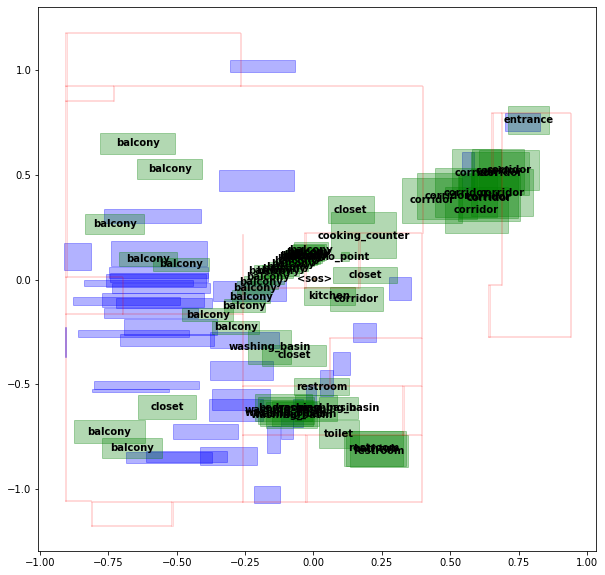

In [199]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (10,10))

c = 0
ax.plot([c, c],[c, c])
ax.autoscale()

for idx, (category) in enumerate(lst_tok):
    
    x_min_val = output_coord[0, idx, 0]
    y_min_val = output_coord[0, idx, 1]
    x_max_val = output_coord[0, idx, 2]
    y_max_val = output_coord[0, idx, 3]
    
    w = x_max_val - x_min_val
    w = 0.005 if w == 0 else w
    h = y_max_val - y_min_val
    h = 0.005 if h == 0 else h
    x_min_val = x_min_val #- m_x
    y_min_val = y_min_val #- m_y
    if category == "wall":
        ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "red", alpha = 0.1))
    elif category == "door":
        ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "blue", alpha = 0.3))
    else:
        rectangle = Rectangle((x_min_val, y_min_val), w, h, color = "green", alpha = 0.3)
        ax.add_patch(rectangle)
        rx, ry = rectangle.get_xy()
        cx = rx + rectangle.get_width()/2.0
        cy = ry + rectangle.get_height()/2.0
        ax.annotate(category, (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')

for idx in range(x[1].shape[1]):
    
    x_min_val = x[1][0, idx, 0]
    y_min_val = x[1][0, idx, 1]
    x_max_val = x[1][0, idx, 2]
    y_max_val = x[1][0, idx, 3]
    
    w = x_max_val - x_min_val
    w = 0.005 if w == 0 else w
    h = y_max_val - y_min_val
    h = 0.005 if h == 0 else h
    x_min_val = x_min_val #- m_x
    y_min_val = y_min_val #- m_y
    ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "red", alpha = 0.1))
plt.show()

In [200]:
lst_tok_real = [train_dataset.index_to_word[i] for i in y[0][0,:,0].tolist()]

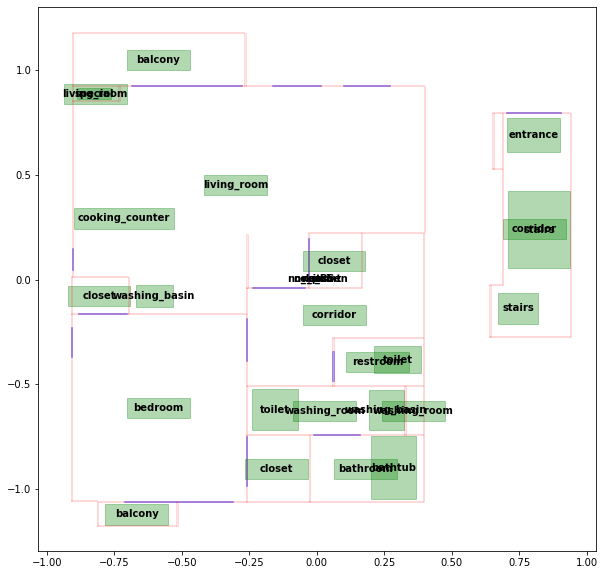

In [201]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (10,10))

c = 0
ax.plot([c, c],[c, c])
ax.autoscale()

for idx, (category) in enumerate(lst_tok_real):
    
#     category = category[0]
    
    x_min_val = y[1][0, idx, 0]
    y_min_val = y[1][0, idx, 1]
    x_max_val = y[1][0, idx, 2]
    y_max_val = y[1][0, idx, 3]
    
    w = x_max_val - x_min_val
    w = 0.005 if w == 0 else w
    h = y_max_val - y_min_val
    h = 0.005 if h == 0 else h
    x_min_val = x_min_val #- m_x
    y_min_val = y_min_val #- m_y
    if category == "wall":
        ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "red", alpha = 0.1))
    elif category == "door":
        ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "blue", alpha = 0.3))
    else:
        rectangle = Rectangle((x_min_val, y_min_val), w, h, color = "green", alpha = 0.3)
        ax.add_patch(rectangle)
        rx, ry = rectangle.get_xy()
        cx = rx + rectangle.get_width()/2.0
        cy = ry + rectangle.get_height()/2.0
        ax.annotate(category, (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')

for idx in range(x[1].shape[1]):
    
    x_min_val = x[1][0, idx, 0]
    y_min_val = x[1][0, idx, 1]
    x_max_val = x[1][0, idx, 2]
    y_max_val = x[1][0, idx, 3]
    
    w = x_max_val - x_min_val
    w = 0.005 if w == 0 else w
    h = y_max_val - y_min_val
    h = 0.005 if h == 0 else h
    x_min_val = x_min_val #- m_x
    y_min_val = y_min_val #- m_y
    ax.add_patch(Rectangle((x_min_val, y_min_val), w, h, color = "red", alpha = 0.1))
    
plt.show()

In [141]:
l = []
lr = 2.
WARMUP_EPOCHS = 10
NUM_EPOCHS = 500 + 1
for epoch_n in range(NUM_EPOCHS):
    if epoch_n < WARMUP_EPOCHS:
        # linear warmup
        lr_mult = float(epoch_n) / float(max(1, WARMUP_EPOCHS))
    else:
        # cosine learning rate decay
        progress = float(epoch_n-WARMUP_EPOCHS)/float(max(1, NUM_EPOCHS/(WARMUP_EPOCHS*0.34)-WARMUP_EPOCHS))
        lr_mult = max(0.05, 0.5 * (1.0 + math.cos(math.pi * progress) )* min(1, 65*epoch_n**-0.88))
    lr_add = lr * lr_mult + lr*0.01
    l.append(lr_add)

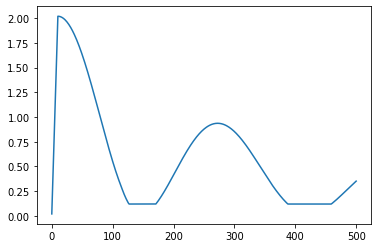

In [142]:
plt.plot(l)